In [13]:
import tensorflow as tf
import tensorflow_io as tfio

# Flac, WAV, Ogg, MP3, and MP4A
audio = tfio.audio.AudioIOTensor('./_data/money_machine.mp3')
#audio = tfio.audio.AudioIOTensor('gs://cloud-samples-tests/speech/brooklyn.flac')

# mono and how many samples?
print(audio.shape)

samplerate = audio.rate.numpy()
print(samplerate)

tf.Tensor([5047688       2], shape=(2,), dtype=int64)
44100


In [14]:
# slicing
audio_t = audio.to_tensor()
audio_slice = audio_t[500000:600000,0]

print(audio_slice)

tf.Tensor(
[ 0.4130604   0.39579287  0.36593807 ... -0.07662006 -0.10862824
 -0.1249968 ], shape=(100000,), dtype=float32)


In [15]:
# play the audio
from IPython.display import Audio

Audio(audio_slice.numpy(), rate=audio.rate.numpy())

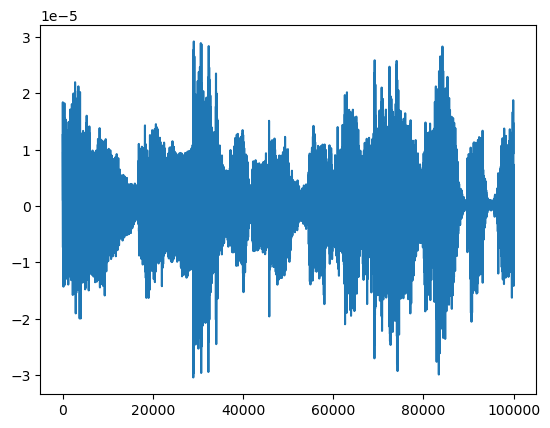

In [16]:
import matplotlib.pyplot as plt


tensor = tf.cast(audio_slice, tf.float32) / 32768.0

plt.figure()
plt.plot(tensor.numpy())


In [17]:
# Lets parse those audacity Label files

with open("_data/money_machine.txt", 'r') as f:
    lines = [l.strip().split('\t') for l in f.readlines()]

# [START, STOP, LABEL]


lines = [[float(l[0]), float(l[1]), l[2]] for l in lines]
print(lines)


for i in [1,2]:
    start = int(lines[i][0]*samplerate)
    end = int(lines[i][1]*samplerate)

    audio_slice = audio_t[ start:end ,0]


Audio(audio_slice.numpy(), rate=samplerate)


[[0.0, 10.206493, 'INTRO'], [10.206493, 19.0, 'VERSE'], [19.0, 39.503548, 'CHORUS'], [39.503548, 48.918398, 'BRIDGE'], [48.918398, 68.136341, 'VERSE'], [68.136341, 87.548404, 'CHORUS'], [87.548404, 97.157375, 'BRIDGE'], [97.157375, 113.948809, 'OUTRO']]


In [18]:
import librosa
from IPython.display import Audio

# by default, librosa samples lower than the original file
money,sample_rate = librosa.load('./_data/money_machine.mp3')

sr=sample_rate
Audio(money, rate=sr)

data1 = money[250000:1000000]

Audio(data1, rate=sr)



[Text(0.5, 1.0, 'Chromagram')]

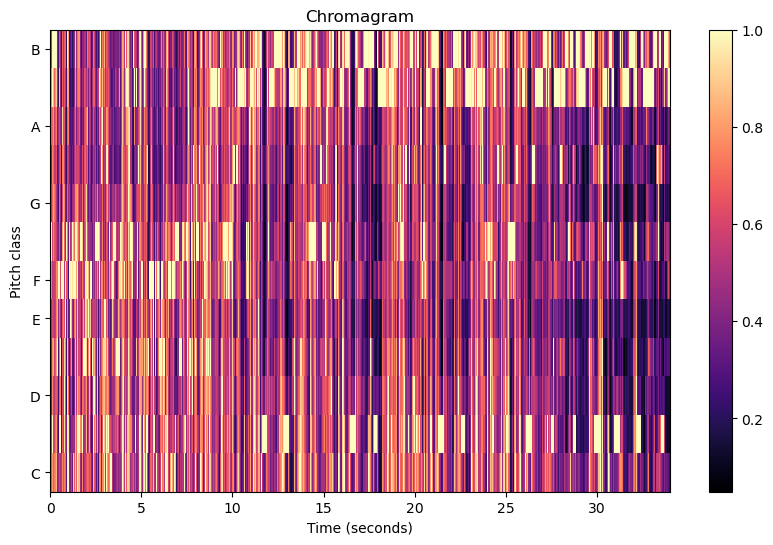

In [19]:
import numpy as np
import matplotlib.pyplot as plt 



C = np.abs(librosa.stft(data1))
chroma = librosa.feature.chroma_stft(S=C, sr=sr)
fig, ax = plt.subplots(figsize=(10,6))
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='s', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Chromagram')

[Text(0.5, 1.0, 'Tempogram')]

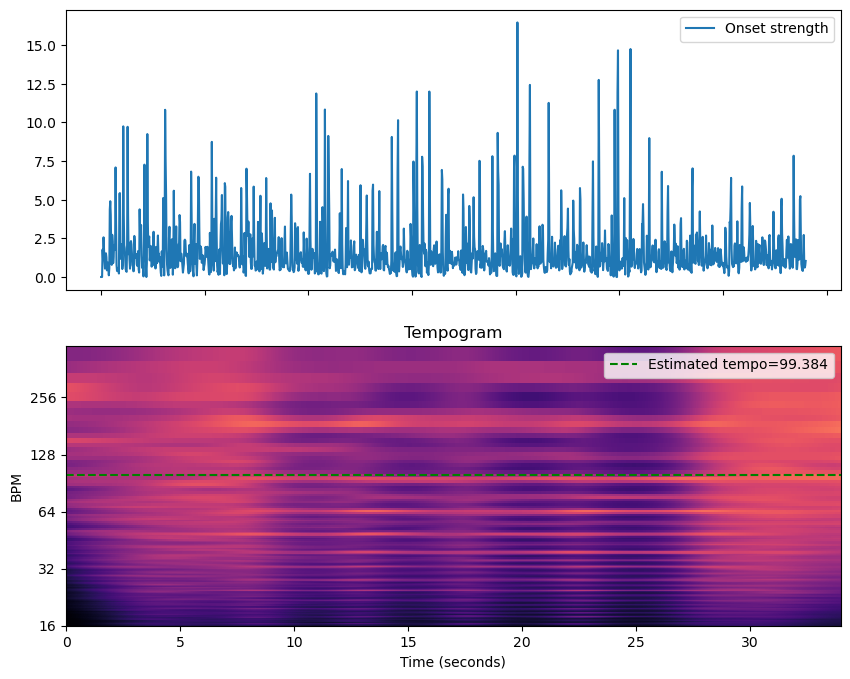

In [20]:
oenv = librosa.onset.onset_strength(y=data1, sr=sample_rate)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sample_rate)
# Compute global onset autocorrelation
ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
ac_global = librosa.util.normalize(ac_global)
# Estimate the global tempo for display purposes
tempo = librosa.feature.tempo(onset_envelope=oenv, sr=sample_rate)[0]
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))
times = librosa.times_like(oenv, sr=sample_rate)
ax[0].plot(times, oenv, label='Onset strength')
ax[0].label_outer()
ax[0].legend(frameon=True)
librosa.display.specshow(tempogram, sr=sample_rate,x_axis='s', 
     y_axis='tempo', cmap='magma',ax=ax[1])
ax[1].axhline(tempo, color='g', linestyle='--', alpha=1,
            label='Estimated tempo={:g}'.format(tempo))
ax[1].legend(loc='upper right')
ax[1].set(title='Tempogram')

In [21]:
import mir_eval

tempo, beats = librosa.beat.beat_track(y=data1, sr=sr)
beat_times = librosa.frames_to_time(beats)
y_tone = mir_eval.sonify.clicks(beat_times,sr,length=len(data1))

import soundfile as sf

#sf.write('moneymachine_section1.wav', data1, sr)
#sf.write('moneymachine_section1_beats.wav', y_tone, sr)


Audio(data1+y_tone,rate=sr)

# Goal

Empty spreadsheet

| Start Time | Section Name | Section (tbd) | Length (bars) | Notes (empty) | Lyrics (empty) |
| ---        | ---          | ---           | ---           |   ---             |   ---         |
| XX:XX      | [from audacity] | [NA]       | 4             | [NA]              |   [NA]        |

In [22]:
# Lets parse those audacity Label files

money,sample_rate = librosa.load('./_data/pain_and_pleasure.m4a',sr=None)

print(money)

# make initial whole-song tempo guess, to feed into segment tempos

avg_tempo = librosa.feature.tempo(y=money,sr=sample_rate)[0]

print(f'initial tempo guess: {avg_tempo}')

with open("_data/pain_and_pleasure2.txt", 'r') as f:
    lines = [l.strip().split('\t') for l in f.readlines()]

# [START, STOP, LABEL]
print(lines)

lines = [[float(l[0]), float(l[1]), l[2]] for l in lines]

# get beats from song

# turn that into a list of sections
# [ {start:time, name:"name"} ]
# if two are within label_radius, use the beat in the middle/closest to them as the time
# if two are outside of label_radius, insert another section in between

label_radius = 1 # second
sections = []

def addSec(l, start, end, name):
    

    startSample = int(start*sample_rate)
    endSample = int(end*sample_rate)

    audio_slice = money[ startSample:endSample ]

    tempo, beats = librosa.beat.beat_track(y=audio_slice, sr=sample_rate, 
                                           start_bpm=avg_tempo, tightness=100)
    beat_times = librosa.frames_to_time(beats)

    # get dumb beats by doing time(min) * bpm
    dumb_beats = (end - start) * avg_tempo / 60
    smart_beats = len(beat_times)
    
    d = {'start':start, 'end':end, 'name':name, 
         'tempo':tempo, 'beat_times':beat_times,
         'slice':audio_slice, 'smart_beats':smart_beats, 'dumb_beats':dumb_beats}

    l.append(d)

if lines[0][0] > label_radius:
    addSec(0, lines[0][0], 'PRE-INTRO')

# for each song
for line in lines:
    # check the start against the previous start
    if (len(sections) > 0) and (line[0] - sections[-1]['end']) > label_radius:
        addSec(sections, sections[-1]['end'], line[0], 'UNKNOWN')
    
    # create one for this song
    addSec(sections, line[0], line[1], line[2])


for s in sections:
    print(len(s['beat_times']))
    print(s['dumb_beats'])



/tmp/ipykernel_240/3427512191.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  money,sample_rate = librosa.load('./_data/pain_and_pleasure.m4a',sr=None)
/home/star/projects/song_structure_proj/songstructure/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


[-2.7465820e-04 -1.5258789e-05  2.4414062e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
initial tempo guess: 161.4990234375
[['0.000000', '12.124255', 'INTRO'], ['12.124255', '24.466474', 'EMPTY VERSE'], ['24.466474', '48.360793', 'VERSE 1'], ['48.360793', '69.285350', 'PRECHORUS'], ['69.285350', '93.179668', 'CHORUS 1'], ['93.179668', '117.128478', 'VERSE 2'], ['117.128478', '141.136851', 'CHORUS 2'], ['141.136851', '153.010823', 'BRIDGE'], ['153.010823', '176.632687', 'SOLO'], ['176.632687', '197.475507', 'PRECHORUS'], ['197.475507', '244.559447', 'CHORUS 3']]
20
32.63425570678711
16
33.2209385925293
62
64.31515307006836
55
56.32159202270506
62
64.315150378418
63
64.46182379150389
60
64.62214656372072
30
31.96058137207026
63
63.58179946289067
54
56.10158459472653
121
126.7335054931641


In [23]:
x = 0

y_tone = mir_eval.sonify.clicks(sections[x]['beat_times'],sample_rate,length=len(sections[x]['slice']))
Audio(sections[x]['slice']+y_tone, rate=sample_rate)

if True:
    sf.write(f'moneymachine_section{x}.wav', sections[x]['slice'], sample_rate)
    sf.write(f'moneymachine_section{x}_beats.wav', y_tone, sample_rate)

In [ ]:
def groupBeats(time_sig, smart_beats, dumb_beats):
    #b = (smart_beats + dumb_beats) / 2
    b = dumb_beats

    groups = [x*time_sig for x in [8, 4, 2, 1]]

    for g in groups:
        rem = b % g
        if rem > g/2:
            rem = g - rem
        if rem < time_sig*0.6:
            return g/time_sig, round(b/g,2)

    return None

for s in sections:
    print(f"{groupBeats(4, s['smart_beats'], s['dumb_beats'])} {s['name']}")

(8.0, 1.02) INTRO
(8.0, 1.04) EMPTY VERSE
(8.0, 2.01) VERSE 1
(2.0, 7.04) PRECHORUS
(8.0, 2.01) CHORUS 1
(8.0, 2.01) VERSE 2
(8.0, 2.02) CHORUS 2
(8.0, 1.0) BRIDGE
(8.0, 1.99) SOLO
(2.0, 7.01) PRECHORUS
(8.0, 3.96) CHORUS 3
